In [2]:
import numpy as np
import pandas as pd
import pyarrow
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows',500)

In [34]:
#Load the data
rated_bookings_file = './Datasets/rated_bookings_with_location.csv'
rb=pd.read_csv(rated_bookings_file)

#Convert to Datetimes
rb['pickup_date'] = pd.to_datetime(rb['pickup_date'])
rb['last_update_date'] = pd.to_datetime(rb['last_update_date'])
rb['booking_date'] = pd.to_datetime(rb['booking_date'])
rb['rating_date'] = pd.to_datetime(rb['rating_date'])

#Load the bookings
bookings_file = './Datasets/all_bookings2.0.csv'
book=pd.read_csv(bookings_file)


In [35]:
'''Column Names
rb.columns
['booking_id', 'supplier', 'status', 'roundtrip_id', 'name',
       'pickup_date', 'pickup_time', 'number_of_passenger', 'vehicle_type',
       'total_price', 'total_comission', 'total_driver', 'special_notes',
       'city_of_departure', 'booking_departure', 'booking_destination',
       'route_type', 'route', 'address', 'hotel', 'flight_number',
       'last_update_date', 'booking_date', 'rating_text', 'country',
       'rating_score', 'rating_date', 'vehicle_category', 'in_or_outbound',
       'airport', 'neighborhood', 'days_in_advance', 'day_in_advance_groups',
       'has_been_updated', 'address_lat', 'address_loc']

book.columns
['status', 'supplier', 'booking_id', 'roundtrip_id', 'name',
       'pickup_date', 'pickup_time', 'number_of_passenger', 'vehicle_type',
       'route_type', 'route', 'total_price', 'total_comission', 'total_driver',
       'special_notes', 'city_of_departure', 'address', 'hotel',
       'flight_number', 'last_update_date', 'booking_date']
'''

Index(['status', 'supplier', 'booking_id', 'roundtrip_id', 'name',
       'pickup_date', 'pickup_time', 'number_of_passenger', 'vehicle_type',
       'route_type', 'route', 'total_price', 'total_comission', 'total_driver',
       'special_notes', 'city_of_departure', 'address', 'hotel',
       'flight_number', 'last_update_date', 'booking_date'],
      dtype='object')

            rating_score                                   
                   count      mean    sum min max       std
pickup_time                                                
00                    78  4.192308    327   1   5  1.520916
01                    28  4.071429    114   1   5  1.537881
02                    48  4.541667    218   1   5  1.236989
03                   135  4.600000    621   1   5  1.016285
04                   163  4.674847    762   1   5  0.895003
05                   200  4.755000    951   1   5  0.773282
06                   209  4.708134    984   1   5  0.835499
07                   358  4.751397   1701   1   5  0.775815
08                   394  4.690355   1848   1   5  0.853407
09                   368  4.682065   1723   1   5  0.912824
10                   344  4.723837   1625   1   5  0.783884
11                   514  4.764591   2449   1   5  0.757697
12                  1519  4.765635   7239   1   5  0.671540
13                  2370  4.682700  1109

<Axes: xlabel='pickup_time', ylabel='mean'>

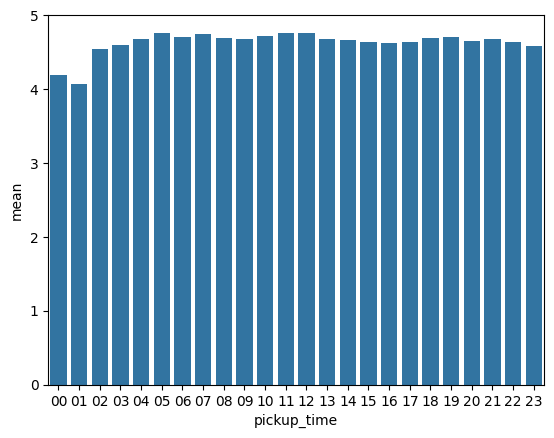

In [30]:
#Ratings per Time of day.
rb['pickup_time'].apply(lambda x: str(x).split(':')[0]).value_counts()

group=rb.groupby(rb['pickup_time'].apply(lambda x: str(x).split(':')[0]))
g1=group.agg({'rating_score':['count', 'mean','sum', 'min', 'max', 'std']})
print(g1)
g1.columns= g1.columns.droplevel()

sns.barplot(data=g1, x='pickup_time', y='mean')


In [17]:
rb['pickup_time']

0        21:00
1        22:35
2        13:50
3        18:30
4        03:00
         ...  
20118    04:00
20119    16:00
20120    19:00
20121    17:10
20122    18:55
Name: pickup_time, Length: 20123, dtype: object